# Load the necessary modules.

In [1]:
import jax.numpy as jnp
import rheedium as rh

### Use `autoreload` to reload changed modules, you may disable this for normal use.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
structure_file = rh.inout.parse_cif("../tests/test_data/SrTiO3.cif")

In [4]:
structure_file

CrystalStructure(frac_positions=Array([[ 0.5,  0.5,  0.5, 38. ],
       [ 0. ,  0. ,  0.5, 22. ]], dtype=float64), cart_positions=Array([[1.97256507e+00, 1.97256507e+00, 1.97256506e+00, 3.80000000e+01],
       [1.20784775e-16, 1.20784775e-16, 1.97256506e+00, 2.20000000e+01]],      dtype=float64), cell_lengths=Array([3.94513013, 3.94513013, 3.94513013], dtype=float64), cell_angles=Array([90., 90., 90.], dtype=float64))

In [5]:
zone_axis = jnp.array([1, 1, 1])
thickness = jnp.asarray([12, 12, 2])

# Now, load the parameters

In [6]:
voltage_kV = 20.0  # Electron beam voltage in kV
theta_deg = 2.0  # Grazing angle
hmax, kmax, lmax = 4, 4, 2  # Reciprocal lattice indexing bounds
detector_distance = 1000.0  # Detector distance in Å
tolerance = 0.05  # Tolerance for Ewald sphere intersection

# Now, we will process things step by step.

## Electron wavelength (Å)

In [7]:
lam_ang = rh.simul.wavelength_ang(voltage_kV)
lam_ang

Array(0.08585529, dtype=float64, weak_type=True)

## Build real-space lattice vectors

In [8]:
cell_vectors = rh.ucell.build_cell_vectors(
    *structure_file.cell_lengths, *structure_file.cell_angles
)

In [9]:
cell_vectors

Array([[3.94513013e+00, 0.00000000e+00, 0.00000000e+00],
       [2.41569549e-16, 3.94513013e+00, 0.00000000e+00],
       [2.41569549e-16, 2.41569549e-16, 3.94513013e+00]], dtype=float64)

## Generate reciprocal lattice vectors

In [10]:
Gs = rh.ucell.generate_reciprocal_points(
    crystal=structure_file, hmax=hmax, kmax=kmax, lmax=lmax, in_degrees=True
)

## Incident wavevector

In [11]:
k_in = rh.simul.incident_wavevector(lam_ang, theta_deg)

## Allowed reflections by kinematic scattering conditions

In [12]:
allowed_indices, k_out = rh.simul.find_kinematic_reflections(
    k_in=k_in,
    gs=Gs,
    tolerance=tolerance,
)

# Simplified approach: Use the high-level simulate_rheed_pattern function

In [13]:
# Generate RHEED pattern for SrTiO3 from [111] surface
# This uses the high-level function that handles all the steps automatically
pattern_111 = rh.simul.kinematic_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    lmax=lmax,
    tolerance=tolerance,
    detector_distance=detector_distance,
    z_sign=-1.0,  # Standard RHEED geometry
    temperature=300.0,
    surface_roughness=0.5,
    detector_acceptance=0.01,
    surface_fraction=0.3,
)
pattern_111

RHEEDPattern(G_indices=Array([193, 197, 198, 202, 203, 207, 208, 213], dtype=int32), k_out=Array([[73.13885658, -3.18528672, -0.96142179],
       [73.13885658, -1.59264336, -2.55406515],
       [73.13885658, -1.59264336, -0.96142179],
       [73.13885658,  0.        , -2.55406515],
       [73.13885658,  0.        , -0.96142179],
       [73.13885658,  1.59264336, -2.55406515],
       [73.13885658,  1.59264336, -0.96142179],
       [73.13885658,  3.18528672, -0.96142179]], dtype=float64), detector_points=Array([[-43.55122392, -13.14515753],
       [-21.77561196, -34.92076949],
       [-21.77561196, -13.14515753],
       [  0.        , -34.92076949],
       [  0.        , -13.14515753],
       [ 21.77561196, -34.92076949],
       [ 21.77561196, -13.14515753],
       [ 43.55122392, -13.14515753]], dtype=float64), intensities=Array([ 13.49784886,  83.79049996,  58.46742102, 152.58331612,
       100.98324423,  83.79049996,  58.46742102,  13.49784886],      dtype=float64))

## Check how many reflections were found

In [14]:
print(f"Number of allowed reflections: {len(pattern_111.intensities)}")
print(f"Shape of detector points: {pattern_111.detector_points.shape}")
print(f"Intensity range: [{pattern_111.intensities.min():.2e}, {pattern_111.intensities.max():.2e}]")

Number of allowed reflections: 8
Shape of detector points: (8, 2)
Intensity range: [1.35e+01, 1.53e+02]


## Plot the simulated RHEED pattern

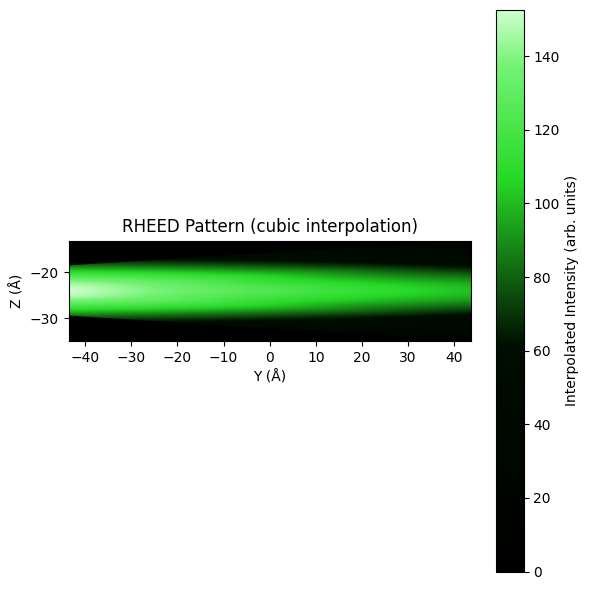

In [15]:
rh.plots.plot_rheed(pattern_111, grid_size=400, interp_type="cubic")

# Understanding the RHEED Pattern Orientation

**Current Issue:** The pattern shows horizontal spots instead of vertical streaks because:

1. The incident beam geometry: `incident_wavevector` creates a beam along the x-axis
2. The detector projection in `project_on_detector` uses the y-z plane
3. For vertical streaks, we need the beam to come from a different azimuthal direction

**To get vertical streaks (correct RHEED geometry):**
- Crystal [111] should be surface normal (z-axis) 
- Beam should propagate in x-z plane at grazing angle
- Streaks will then be vertical along the detector

**Note:** Before plotting, restart the kernel to pick up the bug fix in figuring.py

# Generate pattern with VERTICAL streaks (proper RHEED geometry)

Now using phi_deg=90 to get vertical streaks (beam along y-axis)

In [16]:
# Generate RHEED pattern with VERTICAL streaks
pattern_vertical = rh.simul.kinematic_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    phi_deg=90.0,  # KEY: phi=90 rotates beam to y-axis, giving vertical streaks!
    hmax=hmax,
    kmax=kmax,
    lmax=lmax,
    tolerance=tolerance,
    detector_distance=detector_distance,
    z_sign=-1.0,
    temperature=300.0,
    surface_roughness=0.5,
    detector_acceptance=0.01,
    surface_fraction=0.3,
)

print(f"Number of reflections: {len(pattern_vertical.intensities)}")
print(f"Detector points shape: {pattern_vertical.detector_points.shape}")
print("\nDetector coordinates (horizontal, vertical):")
print(pattern_vertical.detector_points)

Number of reflections: 8
Detector points shape: (8, 2)

Detector coordinates (horizontal, vertical):
[[ 4.35512239e+01 -1.31451575e+01]
 [ 2.17756120e+01 -3.49207695e+01]
 [ 2.17756120e+01 -1.31451575e+01]
 [-1.07857976e-29 -3.49207695e+01]
 [-1.07857976e-29 -1.31451575e+01]
 [-2.17756120e+01 -3.49207695e+01]
 [-2.17756120e+01 -1.31451575e+01]
 [-4.35512239e+01 -1.31451575e+01]]


# Proper Solution: Using SlicedCrystal for True [111] Surface

The new `SlicedCrystal` type properly orients the crystal!

In [17]:
# Create a properly oriented [111] surface slab
slab_111 = rh.types.bulk_to_slice(
    bulk_crystal=structure_file,
    orientation=jnp.array([1, 1, 1]),  # (111) surface
    depth=20.0,  # 20 Å deep
    x_extent=150.0,  # 150 Å wide
    y_extent=150.0   # 150 Å tall
)

print(f"Created [111] surface slab:")
print(f"  Number of atoms: {slab_111.cart_positions.shape[0]}")
print(f"  Orientation: {slab_111.orientation}")
print(f"  Dimensions: {slab_111.x_extent} x {slab_111.y_extent} x {slab_111.depth} Å")
print(f"  Z range: {slab_111.cart_positions[:, 2].min():.2f} to {slab_111.cart_positions[:, 2].max():.2f} Å")

Created [111] surface slab:
  Number of atoms: 81
  Orientation: [1 1 1]
  Dimensions: 150.0 x 150.0 x 20.0 Å
  Z range: 0.00 to 18.22 Å


## Plot with vertical streaks

**Note:** Restart the kernel first to pick up the code changes!

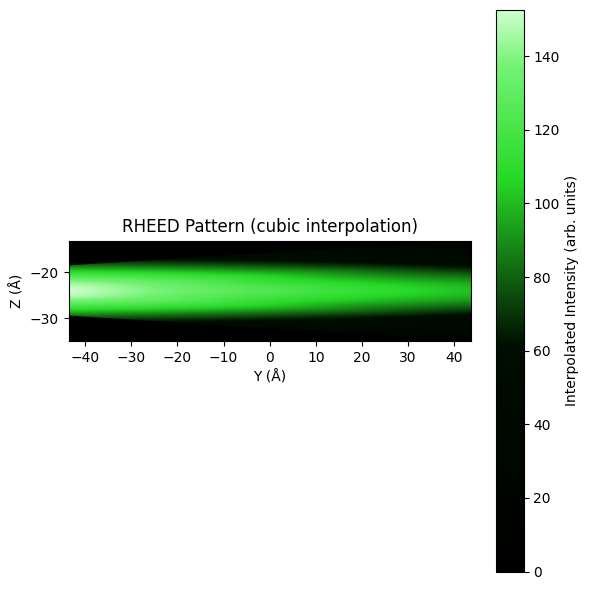

In [18]:
rh.plots.plot_rheed(pattern_vertical, grid_size=400, interp_type="cubic")

# Test Multislice Simulator

Now let's test the new multislice (dynamical) simulator with the SlicedCrystal!

In [19]:
# Convert the SlicedCrystal to PotentialSlices
potential = rh.simul.sliced_crystal_to_potential(
    sliced_crystal=slab_111,
    slice_thickness=2.0,  # 2 Å per slice
    pixel_size=0.5,  # 0.5 Å pixels (balance between accuracy and speed)
    voltage_kv=voltage_kV
)

print(f"PotentialSlices created:")
print(f"  Shape: {potential.slices.shape}")
print(f"  Slice thickness: {potential.slice_thickness} Å")
print(f"  Pixel size: ({potential.x_calibration}, {potential.y_calibration}) Å")

PotentialSlices created:
  Shape: (10, 300, 300)
  Slice thickness: 2.0 Å
  Pixel size: (0.5, 0.5) Å


## Simulate RHEED pattern using multislice

This uses the dynamical diffraction algorithm that accounts for multiple scattering.

In [21]:
# Simulate RHEED pattern with multislice
pattern_multislice = rh.simul.multislice_simulator(
    potential_slices=potential,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    phi_deg=90.0,  # Vertical streaks
    detector_distance=detector_distance,
    detector_width=200.0,  # mm
    detector_height=200.0,  # mm
    detector_pixels_x=256,  # Reduced for speed
    detector_pixels_y=256,
)

print(f"Multislice RHEED pattern:")
print(f"  Number of points: {len(pattern_multislice.intensities)}")
print(f"  Intensity range: [{pattern_multislice.intensities.min():.2e}, {pattern_multislice.intensities.max():.2e}]")

Multislice RHEED pattern:
  Number of points: 47045
  Intensity range: [2.34e-08, 8.00e+09]


## Compare kinematic vs multislice

Kinematic approximation: single scattering, fast, good for thin samples
Multislice: multiple scattering, slower, accurate for thick samples

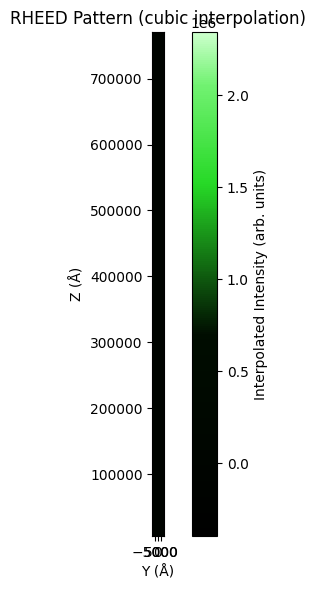

In [22]:
# Plot the multislice RHEED pattern
rh.plots.plot_rheed(pattern_multislice, grid_size=512, interp_type="cubic")